In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_predict,  train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (make_scorer, accuracy_score,
                             classification_report, confusion_matrix,
                             recall_score, precision_score)

In [3]:
from survival_analysis.model_fitter import * 

In [4]:
prefix = '/slade/home/pl450/Uveitis/GRS/python_analysis/'
data = (pd
        .read_csv(prefix + 'allGRS_forROCAUC_220524.tsv',
                  sep='\t', low_memory=False)
        .dropna(subset=['Sex']))

In [5]:
data = pd.get_dummies(data, columns = ['Sex',], drop_first=False)
data.drop(labels='Sex_Male', axis=1, inplace=True)
data.loc[data.white_british!=1, 'white_british'] = 0

In [6]:
smoking_status_map = {
    -3: 'missing',
    0: 'no',
    1: 'yes'
}

data['ever_smoked'] = data['ever_smoked'].replace(smoking_status_map)

data = (pd.get_dummies(data, columns =['ever_smoked'], drop_first=False)
        .drop(labels='ever_smoked_no', axis=1))
data['BMI'] = data['BMI'].fillna(data['BMI'].median())

In [7]:
seq_cols = [i for i in data.columns if 'first_uve' in i]

for i in seq_cols:
    
    prev_count = sum(data[i].isna())
    data.loc[data[i]!=1, i] = 0
    new_count = sum(data[i].isna())


In [8]:
data['age_uve_years'] = data['aao_uve']/12


data.loc[(data.age_uve_years >=18.0) & (data.age_uve_years <= 50.0), 'age_uve_binary'] = 1
data.loc[(data.age_uve_years <18.0) | (data.age_uve_years >50.0), 'age_uve_binary'] = 0

bins = [i * 10 for i in range(0, 10)]
data['age_group_uve'] = pd.cut(data['age_uve_years'], bins=bins, labels=bins[1:])

In [9]:
def train_and_evaluate_model(df, target_variable, disease, grs, exclude_columns=None, test_size=0.4, 
                             random_state=42, n_estimators=100, threshold=0.00005,
                             **kwargs):
    """
    Trains a RandomForest model and evaluates it using a specified threshold.
    
    Parameters:
        df (pd.DataFrame): The dataset to use.
        target_variable (str): The name of the target variable column.
        exclude_columns (list): List of column names to exclude from the feature set.
        test_size (float): The proportion of the dataset to include in the test split.
        random_state (int): The seed used by the random number generator.
        n_estimators (int): The number of trees in the forest.
        threshold (float): The threshold for converting probabilities to class labels.
    
    Returns:
        None: Outputs evaluation metrics and feature importances.
    """
    df = prepare_cph_data(data, disease, grs, **kwargs)
    
    
    # Prepare the data
    X = df.drop(columns=exclude_columns) if exclude_columns else df.drop(columns=[target_variable])
    y = df[target_variable]

    # Split data into training and test sets using stratified sampling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                        random_state=random_state, stratify=y)

    # Initialize the RandomForestClassifier
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)

    # Train the model
    rf_classifier.fit(X_train, y_train)

    # Predict probabilities for the test data
    y_probs = rf_classifier.predict_proba(X_test)[:, 1]  # Get probability of the positive class

    # Apply threshold to positive class probabilities to create binary outcomes
    y_pred_custom_threshold = (y_probs >= threshold).astype(int)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred_custom_threshold)
    print(f"Accuracy with threshold {threshold}: {accuracy:.2f}")
    print(classification_report(y_test, y_pred_custom_threshold))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_custom_threshold)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix with Custom Threshold')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

    # Feature importances
    feature_importances = pd.DataFrame(rf_classifier.feature_importances_,
                                       index=X_train.columns,
                                       columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)

Disease formatted as AS
first_uve_AS
uve_to_AS_years
Accuracy with threshold 0.05: 0.86
              precision    recall  f1-score   support

         0.0       0.99      0.87      0.92      1316
         1.0       0.09      0.48      0.14        33

    accuracy                           0.86      1349
   macro avg       0.54      0.68      0.53      1349
weighted avg       0.96      0.86      0.90      1349



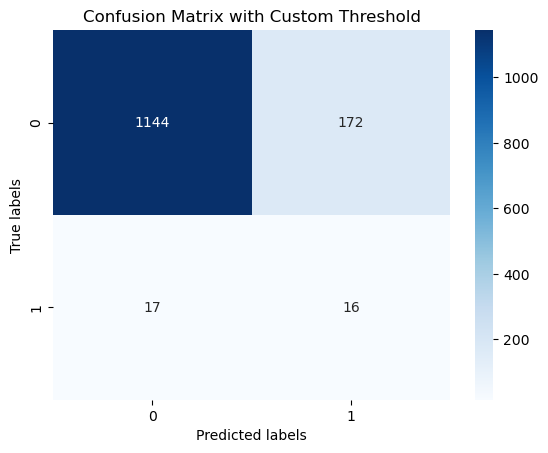

               importance
AS_GRS           0.268819
age_uve_years    0.248328
MS_GRS           0.233687
Psoriasis_GRS    0.228161
B27              0.021004


In [10]:
kwargs = {
    'uve_col': 'uve_any',
    'age_col': 'age_uve_years',
    'add_columns': ['Psoriasis_GRS', 'MS_GRS', 'B27'],
}
train_and_evaluate_model(data, 'first_uve_AS', 'AS_any','AS_GRS',
                         exclude_columns=['first_uve_AS', 'uve_to_AS_years'],
                         threshold=0.05,
                         **kwargs)

In [11]:
def SCVtrain_and_evaluate_model(df, target_variable, disease, grs, exclude_columns=None, test_size=0.4, 
                             random_state=42, n_estimators=100, threshold=0.00005,
                             n_splits=5, **kwargs):
    """
    Trains a RandomForest model with stratified cross-validation and evaluates it using a specified threshold.
    Returns detailed evaluation metrics for each class and average feature importance across all folds.
    
    Parameters:
        df (pd.DataFrame): The dataset to use.
        target_variable (str): The name of the target variable column.
        exclude_columns (list): List of column names to exclude from the feature set.
        test_size (float): The proportion of the dataset to include in the test split.
        random_state (int): The seed used by the random number generator.
        n_estimators (int): The number of trees in the forest.
        threshold (float): The threshold for converting probabilities to class labels.
        n_splits (int): Number of splits for cross-validation.
    
    Returns:
        None: Outputs evaluation metrics and feature importances for each fold.
    """
    df = prepare_cph_data(df, disease, grs, **kwargs)
    
    # Prepare the data
    X = df.drop(columns=(exclude_columns+[target_variable])) if exclude_columns else df.drop(columns=[target_variable])
    y = df[target_variable]

    # Define Stratified K-Folds cross-validator
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Initialize the RandomForestClassifier
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)

    # Collect metrics and feature importances across all folds
    fold_metrics = []
    feature_importances = np.zeros(X.shape[1])

    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit model
        rf_classifier.fit(X_train, y_train)
        
        # Predict probabilities
        y_probs = rf_classifier.predict_proba(X_test)
        
        # Apply custom threshold
        y_pred_custom_threshold = (y_probs[:, 1] >= threshold).astype(int)

        # Calculate metrics
        precision_class = precision_score(y_test, y_pred_custom_threshold, labels=[0,1], average=None)
        recall_class = recall_score(y_test, y_pred_custom_threshold, labels=[0,1], average=None)
        fold_metrics.append((precision_class, recall_class))
        
        # Accumulate feature importances
        feature_importances += rf_classifier.feature_importances_

        # Print fold-specific reports
        print(f"Fold Precision: Class 0: {precision_class[0]:.2f}, Class 1: {precision_class[1]:.2f}")
        print(f"Fold Recall: Class 0: {recall_class[0]:.2f}, Class 1: {recall_class[1]:.2f}")
        cm = confusion_matrix(y_test, y_pred_custom_threshold)
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
        plt.title(f'Confusion Matrix Fold {len(fold_metrics)}')
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.show()

    # Average feature importances
    feature_importances /= n_splits
    feature_importances_df = pd.DataFrame(feature_importances, index=X.columns, columns=['importance']).sort_values(by='importance', ascending=False)
    print(feature_importances_df)

    # Aggregate and print overall metrics
    average_precision = np.mean([metrics[0] for metrics in fold_metrics], axis=0)
    average_recall = np.mean([metrics[1] for metrics in fold_metrics], axis=0)
    print(f"\nOverall Precision - Class 0: {average_precision[0]:.2f}, Class 1: {average_precision[1]:.2f}")
    print(f"Overall Recall - Class 0: {average_recall[0]:.2f}, Class 1: {average_recall[1]:.2f}")

Disease formatted as AS
first_uve_AS
uve_to_AS_years
Fold Precision: Class 0: 0.99, Class 1: 0.05
Fold Recall: Class 0: 0.57, Class 1: 0.88


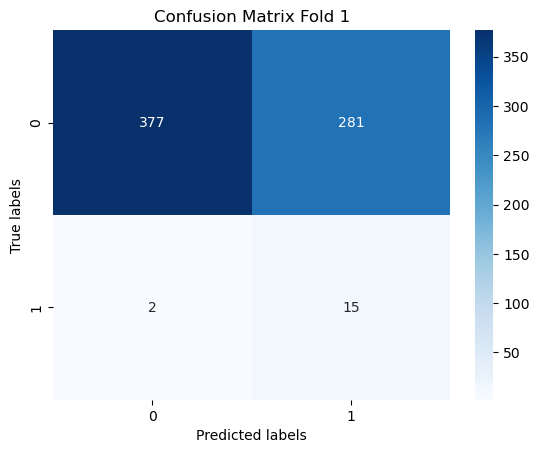

Fold Precision: Class 0: 0.99, Class 1: 0.04
Fold Recall: Class 0: 0.61, Class 1: 0.65


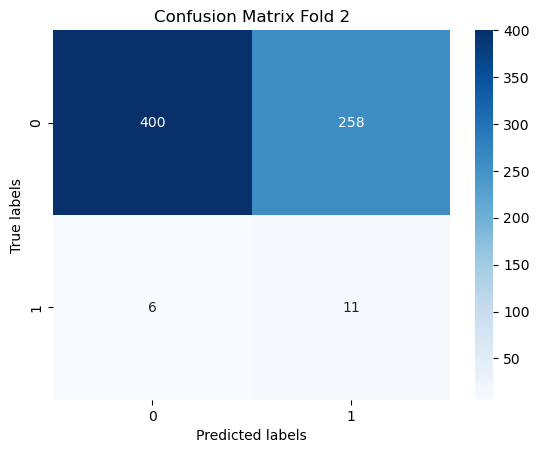

Fold Precision: Class 0: 0.99, Class 1: 0.05
Fold Recall: Class 0: 0.59, Class 1: 0.81


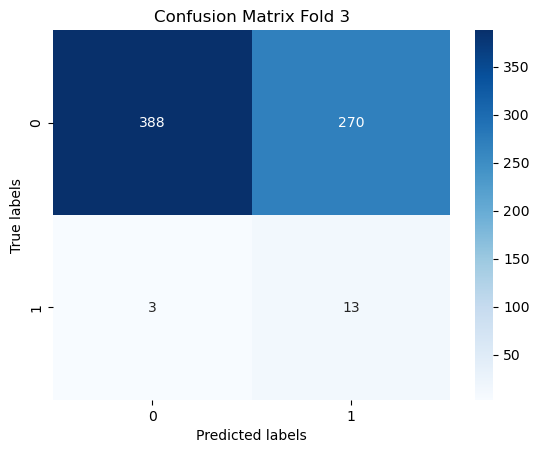

Fold Precision: Class 0: 0.98, Class 1: 0.04
Fold Recall: Class 0: 0.63, Class 1: 0.56


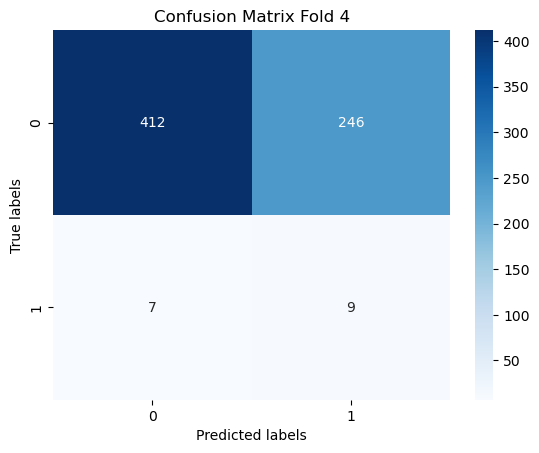

Fold Precision: Class 0: 0.99, Class 1: 0.04
Fold Recall: Class 0: 0.57, Class 1: 0.76


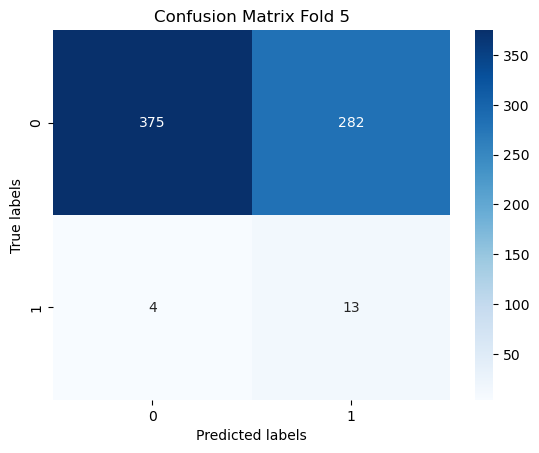

               importance
AS_GRS           0.270416
MS_GRS           0.241252
age_uve_years    0.238467
Psoriasis_GRS    0.225397
B27              0.024468

Overall Precision - Class 0: 0.99, Class 1: 0.04
Overall Recall - Class 0: 0.59, Class 1: 0.73


In [12]:
# Example usage, assuming appropriate data and parameters are defined:
SCVtrain_and_evaluate_model(data, 'first_uve_AS', 'AS_any', 'AS_GRS',exclude_columns=['uve_to_AS_years'],
                         **kwargs)